# Programming Exercise Week 3

## Convolutional Networks and Adversarial Examples


We use the deep learning framework [PyTorch](http://pytorch.org) to implement an image classification system where images of handwritten digits shall be classified.
PyTorch is an open-source deep learning framework that is supported well by the research community.
You can find [PyTorch Tutorials](https://pytorch.org/tutorials) and a large [API Reference Manual](https://pytorch.org/docs/stable) as well as many examples for PyTorch online.

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [1]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

The images that we will use are already pre-cropped and provided by a dataset in PyTorch.
The dataset comes with labeled data, so each of the images is accompanied by an according label (the associated digit class).
Using the provided `transform`, the images are stored as `torch.tensor`s in the format of $C\times H\times W$, where $C$ is the number of color channels (for our images we have only one channel) and $H$ and $W$ are the height and width of the image in pixels.
Let us have a look into some examples:

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 
3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 
4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 
3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 
1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 
3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 
4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 
1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 
9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 
6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 


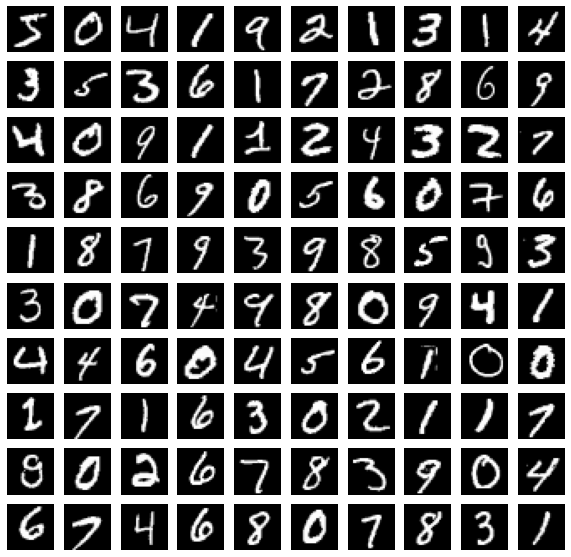

In [2]:
import torch
import torchvision
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

# load the dataset
dataset = torchvision.datasets.MNIST(
  # set automatic downloading of data
  download = True,
  # here, we will use the training set
  train = True,
  # we need to provide a local directory where to download the data to
  root = "./MNIST",
  # we need to convert the images to something that pytorch understands
  transform = torchvision.transforms.ToTensor()
)

# we plot 100 example of images, and we print their respective labels
pyplot.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    # create a subplot for each of the samples
    pyplot.subplot(10, 10, i*10+j+1)
    # get the image and the label from the dataset
    image, label = dataset[i*10+j] 
    # show the image after removing the channel and tranforming it to something, matplotlib understands
    pyplot.imshow(image[0].numpy())
    # remove axiis labels to make the plot more beautiful
    pyplot.axis("off")
    # write the labels to console, using the same grid format
    print(label, end=", ")
  print()

## Convolutional Network

In order to work on images, we will make use of a convolutional network with two layers of convolutions (`torch.nn.Conv2d`) and one fully-connected (`torch.nn.Linear`) layer to perform the classification.
The first two layers are followed by a non-linearity so that the output of the network can form non-linear combinations of input pixels.
Finally, the fully-connected layer needs to output 10 values, one for each digit class.

[Convolutional Layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) in `PyTorch` have several parameters, including:

* `kernel_size`: The size of the kernel, can be specified as a single `int` or a tuple of two `int`'s.
* `out_channels`: The number of produced channels, which we need to specify. This is also the number of kernels that we want to be learned in this layer.
* `in_channels`: The number of incoming channels, which should be `1` for the first layer, or the number of output channels of the previous convolutional layer.
* `padding`: How many pixels should be padded on both sides of the image / feature map?
* `stride`: How many pixels should we step for applying our kernels.

Also, [Fully-connected Layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) have a few parameters:

* `out_features`: The selected dimension that is produced by this layer.
* `in_features`: The dimension of the incoming data.

Different [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) exist, including `torch.nn.ReLU`, `torch.nn.Sigmoid` and `torch.nn.Tanh`.

## Task 1: Network implementation

First, we need to select an appropriate set of parameters of the layers.
Decide, how large the kernels are, how many input and output channels we need in each convolution, if and how you do down-scaling of the convolution results, and which non-linearity should be applied.
Determine the number of parameters that are output from the last convolution layer and input to the fully-connected layer -- how can you compute the number without computing it?

For the implementation of our network, you can rely on the [Sequential Execution](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) of layers as provided in the `torch.nn.Sequential` model that connects the layers in the given order.
Remember that the last fully-connected layer needs to have 10 outputs, one for each class.

In [3]:
convolutional_network = torch.nn.Sequential(
  # first convolutional layer
  torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 0, stride = 2),

  # activation function
  torch.nn.Tanh(),

  # more convolutional layers?
  torch.nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 5, padding = 0, stride = 2),
  torch.nn.Tanh(),

  # converting the channeled structure into one-dimensional data
  torch.nn.Flatten(),

  # Apply fully-connected layer(s)
  torch.nn.Linear(256, 10)
)

## Train the Network


In order to train our convolutional network on our training data, we need to define how large the error is that our current network is making.
For example, when we present the network with a sample of class 4, and the network predicts a 9 with 95% confidence, the error should be high.
When showing a sample of class 3 and the network predicts a 3 with 60% confidence, the error is not that high.

There are several choices of [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions), such as the mean squared error `torch.nn.MSE`, the binary cross-entropy (BCE) loss `torch.nn.BCELoss`, the negative log-likelihood (NLL) loss `torch.nn.NLLLoss` a.k.a. the categorical cross-entropy (CCE) loss, as well as combinations of activation and loss functions such as logistic activation and BCE loss `torch.nn.BCEWithLogitsLoss`, or SoftMax activation with NLL loss `torch.nn.CrossEntropyLoss`.

## Task 2: Loss Function

Select the loss function that best fits to your network implementation and the desired task.

In [4]:
# select an appropriate loss function
loss = torch.nn.CrossEntropyLoss()

As the second component of our training, we need to decide which learning strategy we want to apply.
Several such strategies termed [Optimizers](https://pytorch.org/docs/stable/optim.html) are implemented in `PyTorch`, such as stochastic gradient descent (SGD) `torch.optim.SGD`, RMSProp `torch.optim.RMSProp`, or adaptive moments (Adam) `torch.optim.Adam`.
All of these require a set of learnable `parameters` that shall be optimized -- all the weights/parameters of our network layers -- as well as a carefully selected learning rate `lr`.
Some optimizers have further parameters, which can be obtained through the documentation.

## Task 3: Optimizer

Select an optimizer and a learning rate.
What would be a good strategy to select an appropriate learning rate?
How can we tell if one optimizer is better than the other?

In [5]:
# extract the parameters that we want to optimize
learnable_parameters = convolutional_network.parameters()

# select an optimizer and pass on these learnable parameters
optimizer = torch.optim.SGD(learnable_parameters, lr=0.01, momentum=0.9)

## Parallel Data Processing

To speed up processing, we will be working with batches of samples.
PyTorch provides a simple interface for creating batches, a so-called data loader.
The data loader takes a dataset (such as our MNIST dataset) and a desired batch size, and will provide us with batches of images and labels.
How large the batch size should be is an open debate, usually people use batches as large as fits their GPU memory -- typically restricted to powers of 2: `32, 64, 128, 256, ...`.

In [6]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True)

To further speed up processing, we will run on the GPU.
For this, we can select the specific device `"cuda"`, onto which all of the parameters and the data will be ported.
We here start with porting the parameters of the network, later we need to remember to also port all inputs and labels onto the device.

There are several ways to port samples to devices. Choose one of them.

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
convolutional_network = convolutional_network.to(device)

## Network Training

For training the network on the training data, we iterate over the batches of our dataset and perform a weight update step for each batch.
For this purpose, we first need to pass our input through the network, which is done by using the `__call__` operator, i.e., just call the network object as if it would be a function.
Like this, you will obtain the output of the network, which is the logits that will be fed into the SoftMax function to obtain one probability value for each class for each sample.
These logits will be passed to our `loss` function that will estimate how well the output of the network fits to our labels.
From this loss value (which is a `torch.tensor` with a single element), we can compute the gradient of the loss with respect to all learnable parameters of the network.
In `PyTorch`, this is done using the `tensor.backward()` function.
Finally, the optimizer will perform the update step, i.e., modify the learnable parameters such that the loss value gets minimized.

## Task 4: Training

Write a function that uses the above-declared loss function, the optimizer and the data loader to train on all of the samples once. 
Do not forget to put all the input and labels to the same device as the network's parameters are.

In [8]:
def train():
  """This function iterates over the training set once and trains the network with batches of data"""
  # iterate over all batches of inputs and labels
  for inputs, labels in data_loader:
    # put the data onto the same device as the model
    inputs, labels = inputs.to(device), labels.to(device)

    # forward the data trough the network
    logits = convolutional_network(inputs)

    # compute the loss between the network output and the labels
    J = loss(logits, labels)

    # compute the gradients of the loss w.r.t. the learnable parameters
    J.backward()
    # perform a weight update step
    optimizer.step()

    # clear the gradients to start freshly next round
    # DO NOT REMOVE!
    optimizer.zero_grad()

## Network Validation

In order to assess the quality of the training and to detect overfitting, people regularly evaluate their network's behavior on unseen data.
They define a validation set of annotated samples, for which they compute some metrics, such as the validation loss (using the loss function from above) or by assessing the classification accuracy.
For this validation set, we will use the same structure, i.e., batches of samples from a dataset.
For our small MNIST example in this exercise, we make use of the test set for our validation purposes.

In [9]:
# instantiate the validation set
validation_set = torchvision.datasets.MNIST(root="MNIST", train=False, download=True, transform=torchvision.transforms.ToTensor())
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100)

For computing the accuracy of the network on the validation set, we need to have an implementation that takes batches of network outputs (logits).
We count, how often the maximum output of a sample is identical to the class index, and we return this number and the total number of samples in the given batch.
Remember that the `logits` are in dimension $B\times O$, where $B$ is the size of the batch and $O=10$ is the number of classes, while the target `labels` is of size $B$ and contains the class index of the correct class for each sample in the batch.
We compute the number of correctly classified samples of the whole validation set and divide this number by the number of validation samples to get the accuracy value.

## Task 5: Validation Accuracy

Implement a function that iterates over the validation set and computes the validation accuracy.

In [12]:
def predicted_classes(logits):
  # For each sample, we compute the index that corresponds to the maximum value
  return torch.argmax(logits, dim =1) 

def validation_accuracy():
  number_of_correctly_classified_samples = 0
  total_number_of_samples = len(validation_set)

  # iterate over all batches in the validation set
  for inputs, labels in validation_loader:
    # put the data onto the same device as the model
    inputs, labels = inputs.to(device), labels.to(device)

    # forward the inputs through the network
    logits = convolutional_network(inputs)
    # compute how many samples in the batch were correctly classified
    number_of_correctly_classified_samples += sum(predicted_classes(logits) == labels)
    
  # return the accuracy
  return number_of_correctly_classified_samples / total_number_of_samples

## Training Loop

Finally, we can implement our training loop, where we train the network for several epochs.
In each epoch, we first train the network on the training data (using our `train` function), and then we calculate and report the validation set accuracy.
During validation, since there is no need to calculate gradients, we will disable the gradient computation temporarily.

Note: for well-chosen parameters, the validation accuracy should be above 90% after the first epoch already.
Running this cell might require several minutes, depending on your chosen parameters.

In [13]:
for epoch in range(10):
  # train the network
  train()
  # disable gradient computation during validation
  with torch.no_grad():
    # compute validation accuracy
    acc = validation_accuracy()
  # report it
  print(f"Epoch {epoch+1}: accuracy {acc:1.4f}")

Epoch 1: accuracy 0.9810
Epoch 2: accuracy 0.9824
Epoch 3: accuracy 0.9812
Epoch 4: accuracy 0.9826
Epoch 5: accuracy 0.9824
Epoch 6: accuracy 0.9820
Epoch 7: accuracy 0.9825
Epoch 8: accuracy 0.9819
Epoch 9: accuracy 0.9828
Epoch 10: accuracy 0.9835


## Evaluation of our Network


Now, we can see how well the separate classes have been trained.
For this purpose, we compute the confusion matrix between the predicted classes of the validation set samples and their labels.

Since the majority of samples are correctly classified, we might ignore these cases in our confusion matrix since otherwise the other samples are barely visible.

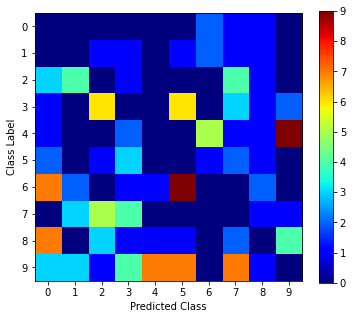

In [14]:
confusion_matrix = torch.zeros((10,10))
with torch.no_grad():
  for inputs, labels in validation_loader:
    # get output of network
    logits = convolutional_network(inputs.to(device))
    # get the predicted classes from the logits
    predicted = predicted_classes(logits)
    # calculate confusion
    confusion_matrix[labels, predicted] += 1

# reset the diagonal to 0
confusion_matrix[torch.eye(10).bool()] = 0

# plot confusion matrix
pyplot.figure(figsize=(6,5))
pyplot.imshow(confusion_matrix, cmap="jet")
# make plot more beautiful
pyplot.xticks(range(10))
pyplot.yticks(range(10))
pyplot.xlabel("Predicted Class")
pyplot.ylabel("Class Label")
pyplot.colorbar()

Now that we have gotten an overview of the errors of the network, let us have a look into the examples that are misclassified.

## Task 6: Collect Wrongly-Classified Samples

Go through the validation set again and collect all the incorrectly classified samples.
For each wrongly-predicted sample, remember its prediction.

In [15]:
# We collect all wrongly-classified samples based on their predicted class
wrong_samples = [[] for o in range(10)] 

with torch.no_grad():
  for inputs, labels in validation_loader:
    # put the data onto the same device as the model
    inputs, labels = inputs.to(device), labels.to(device)
    # get output of network
    logits = convolutional_network(inputs)
    # get the predicted classes from the logits
    predicted = predicted_classes(logits)

    # get the indexes where labels and predicted class mismatch
    indexes = torch.where(predicted != labels)[0]

    inputs = inputs.to("cpu")
    for i in indexes:
      # Store all samples that have been predicted wrongly using the predicted class 
      wrong_samples[predicted[i]].append(inputs[i,0])

Plot all the wrong samples together in one plot such that you can identify their predicted classes.

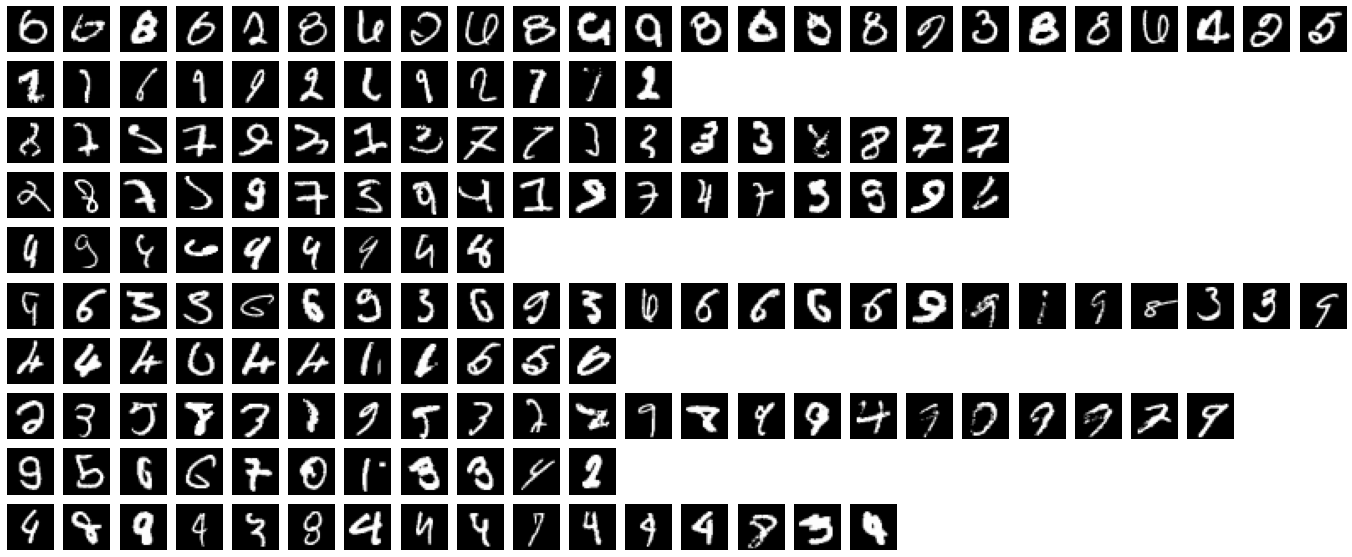

In [16]:
# we plot all images that are wrongly predicted
# first, compute the width of the plot
max_size = max(len(v) for v in wrong_samples)

# create a plot with suddifient space
pyplot.figure(figsize=(max_size, 10))
# iterate over all predicted classes
for i, samples in enumerate(wrong_samples):
  # iterate over the images that have been wrongly predicted as this class
  for j, image in enumerate(samples):
    # plot the image
    pyplot.subplot(10, max_size, i * max_size + j+1)
    pyplot.imshow(image)
    pyplot.axis("off")

## Task 7: Evaluate Wrong Predictions

Go through the list of wrongly predicted samples. 
Did the network make mistakes that you can understand?
Discuss some examples where humans could have made the same mistake, and some examples where the mistake seems unreasonable to humans.

## Bonus: Adversarial Samples


While the network was able to learn to classify digits very well, the question is if it used features that humans would have used, too.
Hence, the question arises: can we modify the images such that we as humans would still see the original label, but we can get the network to classify something else?
Let us try.

First, we need to collect some test samples that are classified correctly by the network.
About 10 for each class should be sufficient.

In [17]:
correct_samples = [[] for o in range(10)] 

with torch.no_grad():
  for inputs, labels in validation_loader:
    # put the data onto the same device as the model
    inputs, labels = inputs.to(device), labels.to(device)
    # get output of network
    logits = convolutional_network(inputs)
    # get the predicted classes from the logits
    predicted = predicted_classes(logits)

    # get the indexes where labels and predicted class match
    indexes = torch.where(predicted == labels)[0]
    for i in indexes:
      correct_samples[predicted[i]].append(inputs[i])
      
# limit to 10 samples per class
correct_samples = [torch.stack(s[:10]) for s in correct_samples]

Now, we implement a simple method where we use the gradient of the loss w.r.t. the pixels of the image in order to modify the image such that the loss is maximized.
PyTorch allows us to do that very simply, but just requesting the gradients for the input images.

We will have a look into two different ways of modifying the input using the gradient of our loss $\mathcal J$: 

$\tilde x = x + \alpha \cdot F(\nabla_x \mathcal J)$

The first method, called the Fast Gradient Sign (FGS) will produce: 

$F_{\mathrm{FGS}}(\nabla_x) = \mathrm{sign}(\nabla_x)$, 

whereas the second version, the Fast Gradient Value (FGV) uses a version of the gradient scaled by its maximum absolute value.

$F_{\mathrm{FGV}}(\nabla_x) = \frac{\nabla_x}{\max |\nabla_x|}$.

# Bonus Task 8: Adversarial Samples (not counting for pass/fail)

We generate FGS and FGV adversarial samples and look at their differences in terms of introduced patterns.
To do that, we iterate through the correctly classified samples collected above and assure that the gradient is requested for the inputs.
Then, we forward the inputs through the network.
We need to compute the loss w.r.t. the original labels and compute the gradients.
We generate adversarial samples by applying FGS or FGV; the gradient should now be stored in `inputs.grad`, which we need to `detach` to be able to work with it.
You should select a value for $0<\alpha\leq1$ that produces little perturbations but changes the network output of most of the samples.
Then, we forward the adversarial samples through the network again and see what classes are now classified.
We write these classes to console, and plot the adversarial samples in a grid.


0 [0, 0, 0, 6, 5, 8, 5, 6, 0, 2]
1 [2, 7, 3, 8, 7, 7, 8, 9, 3, 7]
2 [6, 2, 3, 1, 2, 0, 1, 2, 2, 7]
3 [8, 3, 5, 3, 2, 2, 3, 5, 5, 9]
4 [9, 8, 7, 9, 9, 0, 9, 9, 9, 4]
5 [6, 3, 6, 8, 9, 8, 7, 5, 5, 5]
6 [0, 5, 4, 2, 6, 9, 5, 2, 5, 5]
7 [2, 2, 2, 3, 2, 3, 3, 3, 2, 3]
8 [2, 8, 2, 3, 3, 8, 9, 2, 8, 3]
9 [2, 7, 7, 7, 7, 4, 8, 8, 2, 7]


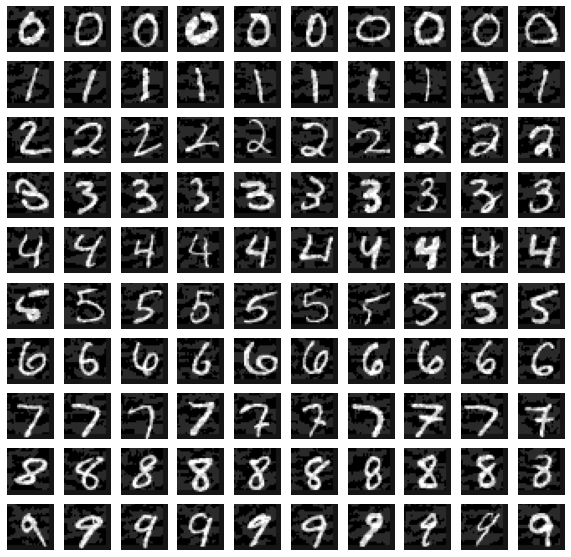

In [18]:
pyplot.figure(figsize=(10,10))

# select an alpha value that works for you
alpha = ...

for label, inputs in enumerate(correct_samples):
  # put the data onto the same device as the model
  inputs = inputs.to(device)
  # we also create a label. Since we have split our correct_samples per class, we can use the list index as the label
  # we just label each of the images in our batch with the same label
  labels = torch.tensor([label]*len(inputs), device=device)

  # now, we request the gradient to be computed for our input (which is not done by default)
  inputs.requires_grad_(True)

  # we run our samples through our network to obtain the logits
  logits = convolutional_network(inputs)
  # we compute the loss w.r.t. the correct class labels
  J = loss(logits, torch.tensor([label]*len(inputs), device=device))
  # and we request pytorch to compute the gradient for us
  J.backward()

  # We obtain the gradient
  grad = inputs.grad.detach()

  # We compute FGS adversarial samples by adding alpha times the sign of the gradient to out input
  adversarial = inputs + 0.1 * torch.sign(grad)

  # Alternative: FGV adds alpha times the normalized gradient
  #max_abs = torch.amax(torch.abs(grad), dim=(1,2,3), keepdim=True)
  #adversarial = inputs + 0.2 * grad / amax

  # predict the classes for the adversarial samples
  logits = convolutional_network(adversarial)
  predicted = predicted_classes(logits)
  print(label, predicted.tolist())

  # plot the resulting images
  for i in range(10):
    ax = pyplot.subplot(10, 10, label*10+i+1)
    ax.imshow(adversarial[i,0].detach().cpu())
    pyplot.axis("off")